# Running jobs on XQC

In [1]:
import numpy as np
from strawberryfields import ops
from strawberryfields import RemoteEngine
import strawberryfields as sf

## Connection

Confirm your connection to Xanadu Cloud's remote devices using:

In [2]:
import xcc.commands
xcc.commands.ping()

'Successfully connected to the Xanadu Cloud.'

## Create your program

We will calculate the vibronic spectrum of ethylene. The vibronic spectrum represents the wavelengths at which light is most strongly absorbed due to electronic and vibrational excitations. Check out the demo [Quantum algorithms on the Xanadu quantum cloud](https://strawberryfields.ai/photonics/demos/tutorial_X8_demos.html) for more details.

In [3]:
U = np.array([
    [-0.5349105592386603,  0.8382670887228271,   0.10356058421030308, -0.021311662937477004],
    [-0.6795134137271818, -0.4999083619063322,   0.5369830827402383,   0.001522863010877817],
    [-0.4295084785810517, -0.17320833713971984, -0.7062800928050401,   0.5354341876268153  ],
    [ 0.2601051345260338,  0.13190447151471643,  0.4495473331653913,   0.8443066531962792  ]
])

In [4]:
prog = sf.Program(8, name="remote_job1")

with prog.context as q:
    # Initial squeezed states
    # Allowed values are r=1.0 or r=0.0
    ops.S2gate(1.0) | (q[0], q[4])
    
    # Interferometer on the signal modes (0-3)
    ops.Interferometer(U) | (q[0], q[1], q[2], q[3])
    ops.Interferometer(U) | (q[4], q[5], q[6], q[7])
    
    ops.MeasureFock() | q

We can use either `"simulon_gaussian"` to run on our remote Gaussian simulator, or `"X8"` to run on our X8 quantum hardware device. Feel free to play around with both (although the simulator might be much slower for many shots).

In [5]:
eng = RemoteEngine("X8")

In [6]:
results = eng.run(prog, shots=20)
print(results.samples)

2022-02-10 13:30:58,212 - INFO - Compiling program for device X8_01 using compiler Xunitary.
2022-02-10 13:31:13,295 - INFO - The remote job 6fc95ee7-4f10-47db-84ab-d753e885d319 has been completed.


[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


Let's print the mean value of the samples. As well as the number of times no photons were measured at all (i.e., the `[0, 0, 0, 0, 0, 0, 0, 0]` case).

In [7]:
print(np.mean(results.samples, axis=0))

[0.25 0.1  0.05 0.05 0.   0.05 0.05 0.  ]


In [8]:
from collections import Counter
bitstrings = [tuple(i) for i in results.samples]
counts = {k:v for k, v in Counter(bitstrings).items()}
print(counts[(0, 0, 0, 0, 0, 0, 0, 0)])

10


## Asynchronous execution

We can also execute the program asynchronously!

In [9]:
job = eng.run_async(prog, shots=3)

2022-02-10 13:31:13,684 - INFO - Compiling program for device X8_01 using compiler Xunitary.


In [10]:
print(job.id)
print(job.status)

cda72c00-6545-459a-8409-2cc08f0500b5
open


In [11]:
job.clear()
job.status

'queued'

In [12]:
job.wait()
print(job.status)

complete


In [13]:
result = sf.Result(job.result)
print(result.samples.shape)

(3, 8)


## Hardware run

Finally, we can attempt to plot the vibronic spectrum of ethylene by running with many shots on the hardware, and by using the vibronic module to calculate the absorption energies.

In [14]:
eng = RemoteEngine("X8")
results = eng.run(prog, shots=400000)
samples = results.samples

2022-02-10 13:31:35,034 - INFO - Compiling program for device X8_01 using compiler Xunitary.
2022-02-10 13:31:59,282 - INFO - The remote job e4c42328-3507-443f-9c6d-5f4329854524 has been completed.


In [15]:
from strawberryfields.apps import vibronic, plot
from matplotlib import pyplot as plt

samples = [list(s) for s in samples]
w = [2979, 1580, 1286, 977]
wp = [2828, 1398, 1227, 855]
energies = vibronic.energies(samples, w, wp)

We can plot the spectra using either `matplotlib` or `plot.ly`.

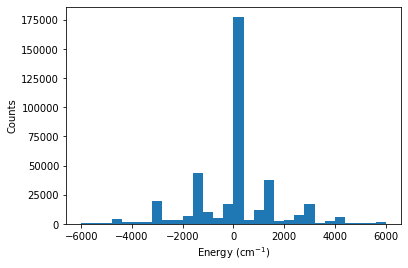

In [16]:
plt.hist(energies, range=[-6000, 6000], bins=30)
plt.ylabel("Counts")
plt.xlabel("Energy (cm$^{-1}$)");